In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
from pathlib import Path
from omegaconf import OmegaConf
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from cohlib.utils import  pickle_open

In [3]:
def plot_synthetic_data2(ax, obs, gamma, xs, zs, lams, trial, trial_color):
    title_size = 12
    label_size = 10
    x = jnp.arange(0, 1000) / 1000
    # for i in range(start,start+3):
    l = trial
    # i = 3
        
    ax[0].plot(x, lams[:,0,l], color=trial_color)
    ax[0].set_title(r'$\lambda_t^{1, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[0].margins(0)
    ax[0].set_ylabel('Intensity', size = label_size)

    ax[2].plot(x, lams[:,1,l], color=trial_color)
    ax[2].set_title(r'$\lambda_t^{2, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[2].margins(0)
    ax[2].set_ylabel('Intensity', size = label_size)

    ax[1].plot(x, obs[:,0,l], color=trial_color)
    ax[1].set_title(r'$\lambda_t^{1, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[1].margins(0)
    ax[1].set_ylabel('Intensity', size = label_size)

    ax[3].plot(x, obs[:,1,l], color=trial_color)
    ax[3].set_title(r'$\lambda_t^{2, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[3].margins(0)
    ax[3].set_ylabel('Intensity', size = label_size)


    ax[3].set_xlabel('Time (sec)', size = label_size)
    # plt.xlim([0,sample_length/fs])


In [4]:
def plot_synthetic_data(ax, obs, gamma, xs, zs, lams, trial, trial_color):
    title_size = 12
    label_size = 10
    x = jnp.arange(0, 1000) / 1000
    # for i in range(start,start+3):
    l = trial
    # i = 3
        
    ax[0].plot(x, lams[:,0,l], color=trial_color)
    ax[0].set_title(r'$\lambda_t^{1, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[0].margins(0)
    ax[0].set_ylabel('Intensity', size = label_size)

    ax[2].plot(x, lams[:,1,l], color=trial_color)
    ax[2].set_title(r'$\lambda_t^{2, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[2].margins(0)
    ax[2].set_ylabel('Intensity', size = label_size)

    ax[4].plot(x, lams[:,2,l], color=trial_color)
    ax[4].set_title(r'$\lambda_t^{2, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[4].margins(0)
    ax[4].set_ylabel('Intensity', size = label_size)

    ax[1].plot(x, obs[:,0,l], color=trial_color)
    ax[1].set_title(r'$\lambda_t^{1, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[1].margins(0)
    ax[1].set_ylabel('Intensity', size = label_size)

    ax[3].plot(x, obs[:,1,l], color=trial_color)
    ax[3].set_title(r'$\lambda_t^{2, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[3].margins(0)
    ax[3].set_ylabel('Intensity', size = label_size)

    ax[5].plot(x, obs[:,2,l], color=trial_color)
    ax[5].set_title(r'$\lambda_t^{2, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[5].margins(0)
    ax[5].set_ylabel('Intensity', size = label_size)


    ax[5].set_xlabel('Time (sec)', size = label_size)
    # plt.xlim([0,sample_length/fs])


In [5]:
from cohlib.jax.dists import sample_from_gamma, sample_obs
from cohlib.jax.observations import add0
def cif_alpha_relu(alphas, xs):
    lams = alphas[None,:,None] + xs
    lams = lams.at[lams < 0].set(0)
    return lams

In [6]:
def plot_spec_em_iters(ax, gamma_iter_list, k, nz=None, dB=False):
    if nz is None:
        nz = jnp.arange(gamma_iter_list[0].shape[0])
    num_iters = len(gamma_iter_list)
    color = plt.cm.rainbow(jnp.linspace(0, 1, num_iters))
    for r, c in enumerate(color): 
        gamma_r = gamma_iter_list[r]
        S_r = gamma_r[nz,k,k].real
        if dB is True:
            S_r = 10*jnp.log10(S_r)
        ax.plot(S_r, color=c, linewidth=2, alpha=0.5)

def db_transform(S_x):
    return 10*jnp.log10(S_x + 1e-15)

def identity(S_x):
    return S_x

In [8]:
def check_attrs(cfg, lcfg_attrs, mcfg_attrs, ocfg_attrs):    
    lcfg_check = [cfg.latent.get(k, None) == v for k, v in lcfg_attrs.items()]
    mcfg_check = [cfg.model.get(k, None) == v for k, v in mcfg_attrs.items()]
    ocfg_check = [cfg.obs.get(k, None) == v for k, v in ocfg_attrs.items()]

    check = jnp.all(jnp.array(lcfg_check + mcfg_check + ocfg_check))
    return check

def filter_load_results(paths, lcfg_attrs, mcfg_attrs, ocfg_attrs):
    sel_paths = []
    for path in paths:
        _dir = Path(path)
        for i, exp in enumerate(_dir.glob('*')):
            cfg_path = os.path.join(exp, '.hydra/config.yaml')
            cfg = OmegaConf.load(cfg_path)

            if check_attrs(cfg, lcfg_attrs, mcfg_attrs, ocfg_attrs):
                sel_paths.append(exp)

    assert len(sel_paths) > 0
    print(f'{len(sel_paths)} paths found meeting critera')

    results = []
    for path in sel_paths:
        cfg_path = os.path.join(path, '.hydra/config.yaml')
        cfg = OmegaConf.load(cfg_path)

        res = pickle_open(os.path.join(path, 'res.pickle'))
        res['cfg'] = cfg
        results.append(res)

    return results


def filter_loaded(loaded, lcfg_attrs, mcfg_attrs, ocfg_attrs):
    filtered = [r for r in loaded if check_attrs(r['cfg'], lcfg_attrs, mcfg_attrs, ocfg_attrs)]
    if len(filtered) == 0:
        print("No results in list to filter.")
    elif len(filtered) == 1:
        print("Returned single result.")
        return filtered[0]
    else:
        print("Multiple results found.")
        return filtered

In [9]:
num_iters = 20
L = 10

lcfg_attrs = {'gamma': 'k3-temp-rank1-nz9'}

mcfg_attrs = {'emiters': num_iters,
              'init': 'empirical-init'}

ocfg_attrs = {'obs_type': 'pp_relu'}

res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/refac_pprelu_obs/batch/outputs/2024-11-19']

res_load = filter_load_results(res_paths, lcfg_attrs, mcfg_attrs, ocfg_attrs)
alphas = sorted([r['cfg'].obs.alpha for r in res_load])


12 paths found meeting critera


In [11]:
L = 10
alpha = 100
lsel = {'L': L}
msel = {'emiters': num_iters,
        'init': 'empirical-init'}
osel = {'alpha': alpha}
res = filter_loaded(res_load, lsel, {}, osel)
cfg = res['cfg']
gamma_true = res['gamma_true_full']
nz = res['params']['nonzero_inds']
K = gamma_true.shape[-1]
Nnz = nz.size

Returned single result.


In [12]:
Ls = jnp.array([10, 25, 50, 100])
alphas = jnp.array([100, 300, 500])

In [13]:
from cohlib.jax.dists import naive_estimator, sample_ccn_rank1
from cohlib.jax.simtools import load_gamma


naive_ests = jnp.zeros((Ls.size, alphas.size, Nnz, K, K), dtype=complex)
oracle_ests = jnp.zeros((Ls.size, alphas.size, Nnz, K, K), dtype=complex)
for l, L in enumerate(Ls):
    for a, alpha in enumerate(alphas):
        print(f'L: {L}, alpha: {alpha}' )
        lsel = {'L': L}
        osel = {'alpha': alpha}
        res = filter_loaded(res_load, lsel, msel, osel)

        
        cfg = res['cfg']
        lcfg = cfg.latent
        ocfg = cfg.obs
        gamma_true = res['gamma_true_full']
        K = gamma_true.shape[-1]

        gamma_load = load_gamma(cfg)
        nz_target = gamma_load['target_inds']
        eigvec = gamma_load['eigvec']
        eigval = gamma_load['eigval']

        lrk = jr.key(lcfg.seed)

        zs_target = sample_ccn_rank1(lrk, eigvec, eigval, K, lcfg.L)
        gamma_full_dummytarget = gamma_true.copy()
        gamma_full_dummytarget = gamma_full_dummytarget.at[nz_target,:,:].set(jnp.eye(K, dtype=complex))

        zs = sample_from_gamma(lrk, gamma_full_dummytarget, lcfg.L)
        zs = zs.at[nz_target,:,:].set(zs_target)

        zs_0dc = jnp.apply_along_axis(add0, 0, zs)
        xs = jnp.fft.irfft(zs_0dc, axis=0)
        params = jnp.array([ocfg.alpha for _ in range(K)])
        print(params)
        lams = cif_alpha_relu(params, xs)


        obs, obs_params = sample_obs(xs, params)
        naive_est = naive_estimator(obs, nz)
        naive_ests = naive_ests.at[l,a,:,:,:].set(naive_est * 1e6)

        gamma_oracle = jnp.einsum('jkl,jil->jkil', zs[nz,:,:], zs[nz,:,:].conj()).mean(-1)
        oracle_ests = oracle_ests.at[l,a,:,:,:].set(gamma_oracle)

L: 10, alpha: 100
Returned single result.
[100 100 100]
L: 10, alpha: 300
Returned single result.
[300 300 300]
L: 10, alpha: 500
Returned single result.
[500 500 500]
L: 25, alpha: 100
Returned single result.
[100 100 100]
L: 25, alpha: 300
Returned single result.
[300 300 300]
L: 25, alpha: 500
Returned single result.
[500 500 500]
L: 50, alpha: 100
Returned single result.
[100 100 100]
L: 50, alpha: 300
Returned single result.
[300 300 300]
L: 50, alpha: 500
Returned single result.
[500 500 500]
L: 100, alpha: 100
Returned single result.
[100 100 100]
L: 100, alpha: 300
Returned single result.
[300 300 300]
L: 100, alpha: 500
Returned single result.
[500 500 500]


In [14]:
def plot_cross_spec_em_iters(ax, i, j, gamma_iter_list, gamma_init, j_ind=9, j_ind_full=9, nz=None):
    cs_real = jnp.array([gamma_init[j_ind_full,i,j].real] + [gamma_r[j_ind,i,j].real for gamma_r in gamma_iter_list])
    cs_imag = jnp.array([gamma_init[j_ind_full,i,j].imag] + [gamma_r[j_ind,i,j].imag for gamma_r in gamma_iter_list])
    ax.plot(cs_real, color='tab:blue', linewidth=2)
    ax.plot(cs_imag, color='tab:red', linewidth=2)

def plot_cross_spec_func_em_iters(ax, func, i, j, gamma_iter_list, gamma_init, j_ind=9, j_ind_full=9, nz=None, color='tab:blue'):
    cs_real = jnp.array([func(gamma_init[j_ind_full,i,j])] + [func(gamma_r[j_ind,i,j]) for gamma_r in gamma_iter_list])
    ax.plot(cs_real, color=color, linewidth=2)

In [16]:
jind = 0
jind_full = 9

Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.


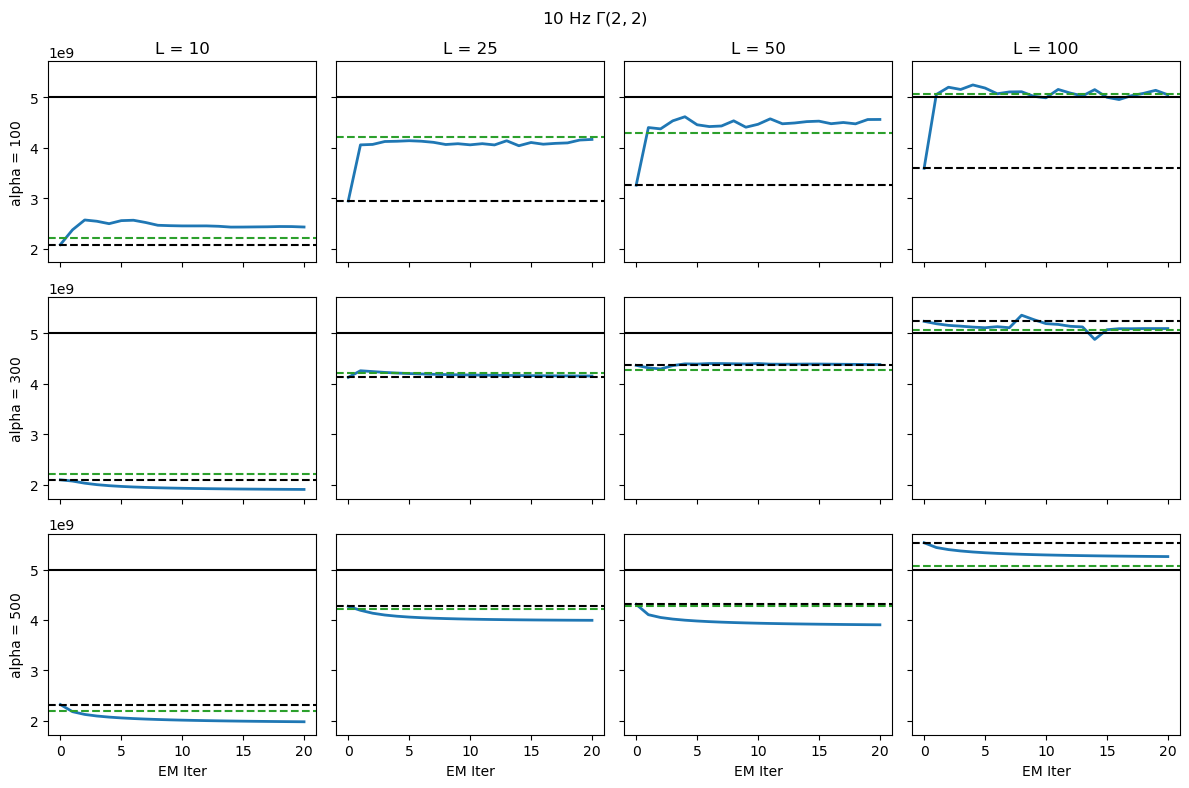

In [19]:
ijs = [[0,0], [1,1], [2,2]]
k = 2

i,j = ijs[k]

fig, ax = plt.subplots(alphas.size, Ls.size, figsize=(12,8), sharex=True, sharey=True)
for l, L in enumerate(Ls):
    for a, alpha in enumerate(alphas):
        
        lsel = {'L': L}
        osel = {'alpha': alpha}
        res = filter_loaded(res_load, lsel, msel, osel)
        cfg = res['cfg']
        gamma_true = res['gamma_true_full']

        func = jnp.real
        plot_cross_spec_func_em_iters(ax[a,l], func, i,j, res['track']['gamma'], res['gamma_init'], j_ind = jind)
        ax[a,l].axhline(func(res['gamma_true_full'][jind_full,i,j]), color='k')
        ax[a,l].axhline(func(naive_ests[l,a,jind,i,j]), linestyle='--', color='k')
        ax[a,l].axhline(func(oracle_ests[l,a,jind,i,j]), linestyle='--', color='tab:green')
        if l == 0:
            ax[a,l].set_ylabel(f'alpha = {alpha}')
        if a == 0:
            ax[a,l].set_title(f'L = {L}')
        if a == alphas.size-1:
            ax[a,l].set_xlabel('EM Iter')
fig.suptitle(f'{nz[jind]+1} Hz ' + rf'$\Gamma({i}, {j})$')
plt.tight_layout()

In [20]:
jnp.angle(gamma_true[9,:,:])

Array([[ 0.        , -2.6778703 ,  2.64746   ],
       [ 2.6778703 ,  0.        , -0.95785505],
       [-2.64746   ,  0.957855  ,  0.        ]], dtype=float32)

Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.


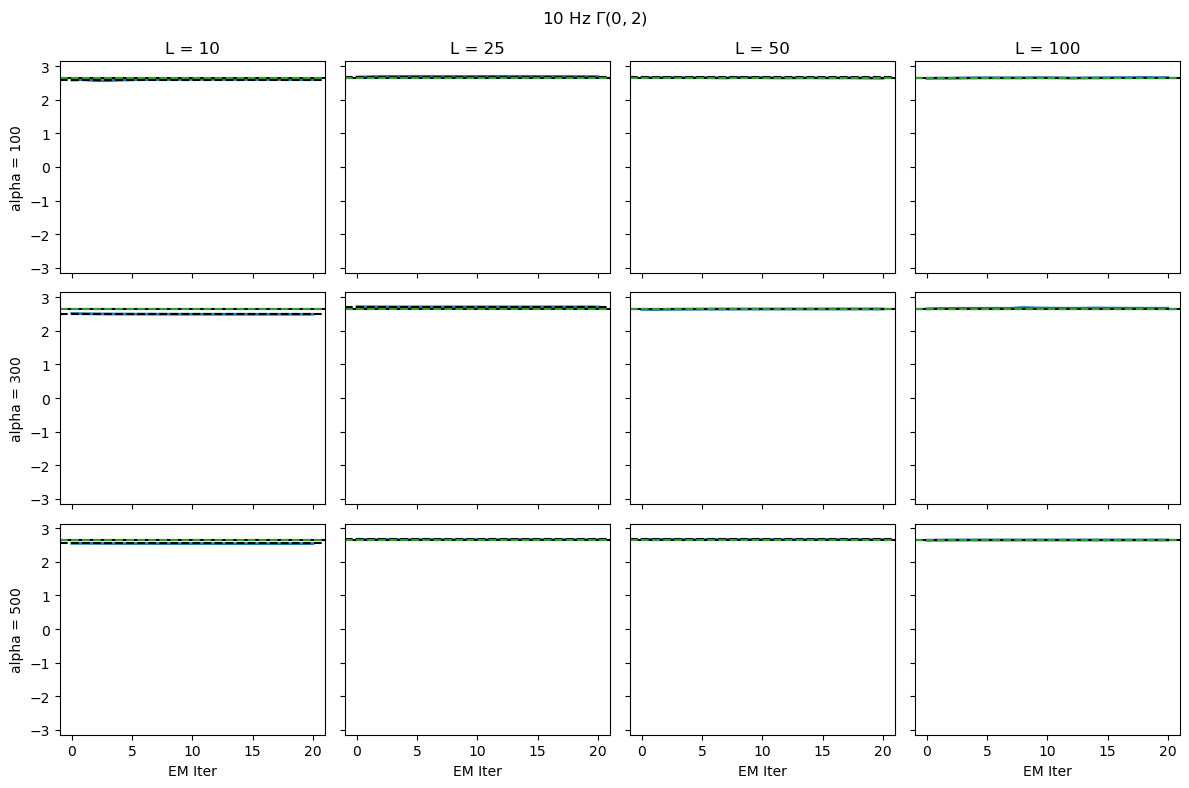

In [23]:
ijs = [[0,1], [0,2], [1,2]]
i,j = ijs[1]
func = jnp.angle

fig, ax = plt.subplots(alphas.size, Ls.size, figsize=(12,8), sharex=True, sharey=True)
for l, L in enumerate(Ls):
    for a, alpha in enumerate(alphas):
        
        lsel = {'L': L}
        osel = {'alpha': alpha}
        res = filter_loaded(res_load, lsel, msel, osel)
        cfg = res['cfg']
        gamma_true = res['gamma_true_full']

        plot_cross_spec_func_em_iters(ax[a,l], func, i,j, res['track']['gamma'], res['gamma_init'], j_ind = jind)
        ax[a,l].axhline(func(res['gamma_true_full'][jind_full,i,j]), color='k')
        ax[a,l].axhline(func(naive_ests[l,a,jind,i,j]), linestyle='--', color='k')
        ax[a,l].axhline(func(oracle_ests[l,a,jind,i,j]), linestyle='--', color='tab:green')
        if l == 0:
            ax[a,l].set_ylabel(f'alpha = {alpha}')
        if a == 0:
            ax[a,l].set_title(f'L = {L}')
        if a == alphas.size-1:
            ax[a,l].set_xlabel('EM Iter')

        ax[a,l].set_ylim([-jnp.pi, jnp.pi])
fig.suptitle(f'{nz[jind]+1} Hz ' + rf'$\Gamma({i}, {j})$')
plt.tight_layout()

In [26]:
def get_eigval(mat, rank):
    eigvals = jnp.linalg.eigh(mat)[0]
    return eigvals[-rank]

def get_eigvec(mat, rank):
    eigvecs = jnp.linalg.eigh(mat)[1]
    return eigvecs[:,-rank]

def plot_cross_spec_eigval_em_iters(ax, eigrank, gamma_iter_list, gamma_init, j_ind=9, j_ind_full=9, nz=None):
    eigs = jnp.array([get_eigval(gamma_init[j_ind_full,:,:], eigrank)] + [get_eigval(gamma_r[j_ind,:,:], eigrank) for gamma_r in gamma_iter_list])
    ax.plot(eigs, color='tab:blue', linewidth=2)

def get_eigvec_em_iters(eigrank, gamma_iter_list, gamma_init, j_ind=9, nz=None):
    eigvecs = jnp.array([get_eigvec(gamma_init[j_ind_full,:,:], eigrank)] + [get_eigvec(gamma_r[j_ind,:,:], eigrank) for gamma_r in gamma_iter_list])
    return eigvecs

def plot_eigvec_func_em_iters(ax, func, eigrank, dim, gamma_iter_list, gamma_init, j_ind=9, nz=None, color='tab:blue'):
    eigvecs = get_eigvec_em_iters(eigrank, gamma_iter_list, gamma_init, j_ind, nz=nz)
    res = func(eigvecs[:,dim])
    ax.plot(res, color=color, linewidth=2)

In [27]:
res['gamma_init']

Array([[[0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j]],

       [[0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j]],

       [[0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j]],

       ...,

       [[0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j]],

       [[0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j]],

       [[0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j]]], dtype=complex64)

Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.


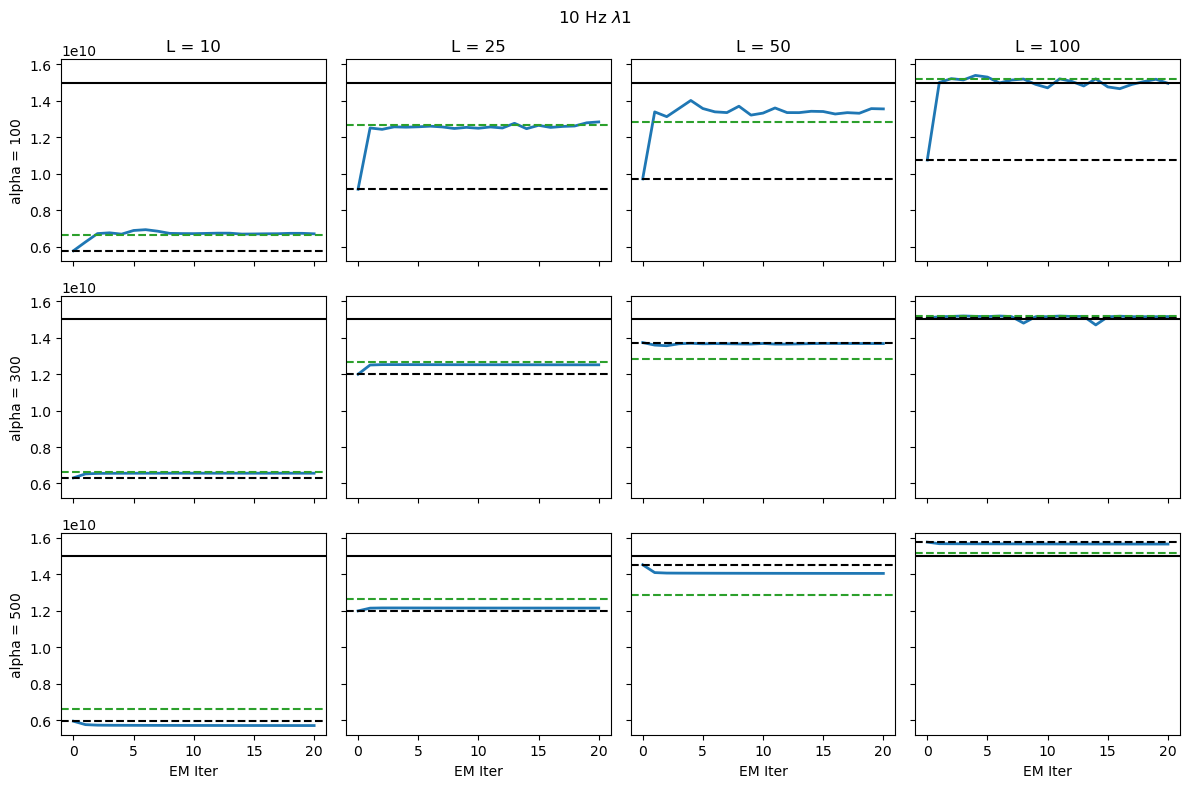

In [28]:
eigrank = 1
fig, ax = plt.subplots(alphas.size, Ls.size, figsize=(12,8), sharex=True, sharey=True)
for l, L in enumerate(Ls):
    for a, alpha in enumerate(alphas):
        
        lsel = {'L': L}
        osel = {'alpha': alpha}
        res = filter_loaded(res_load, lsel, msel, osel)
        cfg = res['cfg']
        gamma_true = res['gamma_true_full']

        true_eigval = get_eigval(gamma_true[jind_full,:,:], eigrank)

        gamma_naive = naive_ests[l,a,:,:,:]
        gamma_oracle = oracle_ests[l,a,:,:,:]

        oracle_eigval = get_eigval(gamma_oracle[jind,:,:], eigrank)
        naive_eigval = get_eigval(gamma_naive[jind,:,:], eigrank)

        plot_cross_spec_eigval_em_iters(ax[a,l], eigrank, res['track']['gamma'], res['gamma_init'], j_ind=jind)
        ax[a,l].axhline(true_eigval, color='k')
        ax[a,l].axhline(naive_eigval, linestyle='--', color='k')
        ax[a,l].axhline(oracle_eigval, linestyle='--', color='tab:green')

        if l == 0:
            ax[a,l].set_ylabel(f'alpha = {alpha}')
        if a == 0:
            ax[a,l].set_title(f'L = {L}')
        if a == alphas.size-1:
            ax[a,l].set_xlabel('EM Iter')

fig.suptitle(f'{nz[jind]+1} Hz ' + rf'$\lambda {eigrank}$')
plt.tight_layout()

Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.


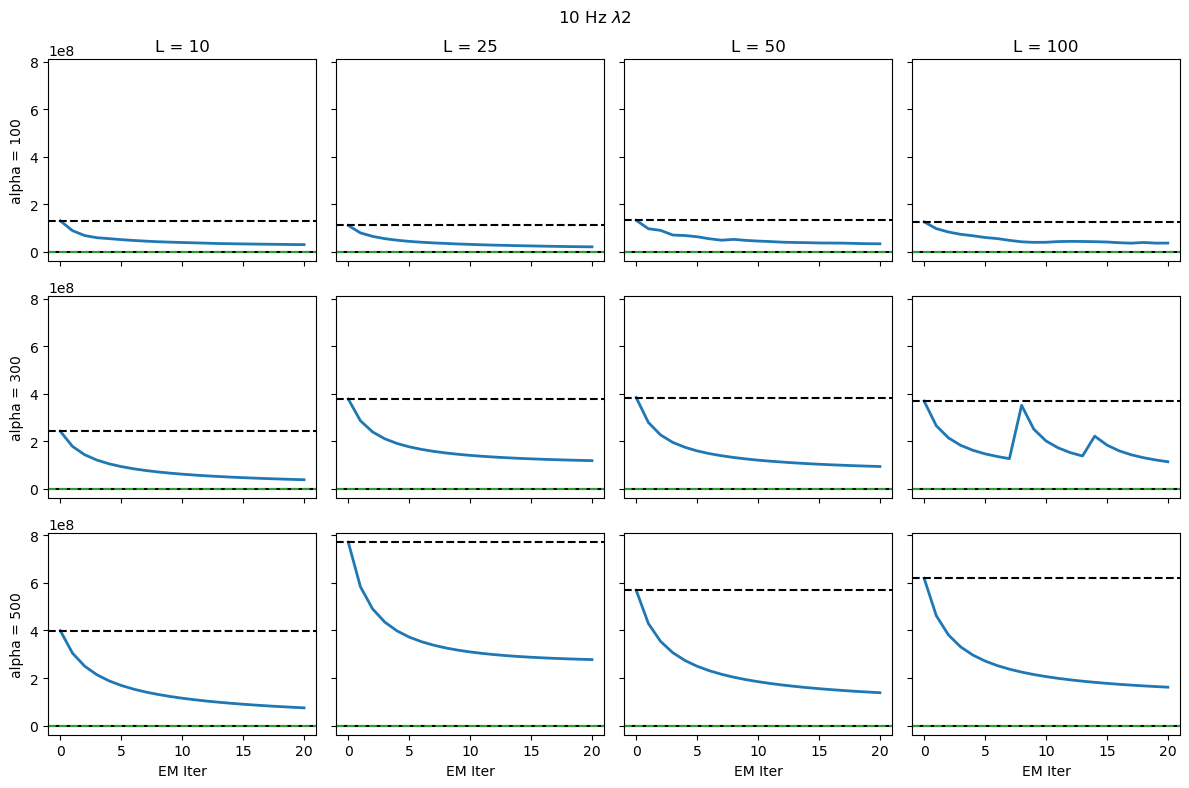

In [29]:
eigrank = 2
fig, ax = plt.subplots(alphas.size, Ls.size, figsize=(12,8), sharex=True, sharey=True)
for l, L in enumerate(Ls):
    for a, alpha in enumerate(alphas):
        
        lsel = {'L': L}
        osel = {'alpha': alpha}
        res = filter_loaded(res_load, lsel, msel, osel)
        cfg = res['cfg']
        gamma_true = res['gamma_true_full']

        true_eigval = get_eigval(gamma_true[jind_full,:,:], eigrank)

        gamma_naive = naive_ests[l,a,:,:,:]
        gamma_oracle = oracle_ests[l,a,:,:,:]

        oracle_eigval = get_eigval(gamma_oracle[jind,:,:], eigrank)
        naive_eigval = get_eigval(gamma_naive[jind,:,:], eigrank)

        plot_cross_spec_eigval_em_iters(ax[a,l], eigrank, res['track']['gamma'], res['gamma_init'], j_ind=jind)
        ax[a,l].axhline(true_eigval, color='k')
        ax[a,l].axhline(naive_eigval, linestyle='--', color='k')
        ax[a,l].axhline(oracle_eigval, linestyle='--', color='tab:green')

        if l == 0:
            ax[a,l].set_ylabel(f'alpha = {alpha}')
        if a == 0:
            ax[a,l].set_title(f'L = {L}')
        if a == alphas.size-1:
            ax[a,l].set_xlabel('EM Iter')

fig.suptitle(f'{nz[jind]+1} Hz ' + rf'$\lambda {eigrank}$')
plt.tight_layout()

In [ ]:
oracle_ests.shape
eigvec_true = gamma_load['eigvec']
eigval_true = gamma_load['eigval']
print(eigvec_true)
test_eigvals, test_eigvecs = jnp.linalg.eigh(eigval * jnp.outer(eigvec_true, eigvec_true.conj()))
eigvec_posttrue = test_eigvecs[:,-1]
print(eigvec_posttrue)
gamma_naive = naive_ests[alpha]
gamma_oracle = oracle_ests[alpha]

eigvec_naive = get_eigvec(gamma_naive[9,:,:], 1)
eigvec_oracle = get_eigvec(gamma_oracle[9,:,:], 1)

eigval_naive = get_eigval(gamma_naive[9,:,:], 1)
eigval_oracle = get_eigval(gamma_oracle[9,:,:], 1)

dims = jnp.arange(K)

for dim in dims:
    fig, ax = plt.subplots(2,1,figsize=(6,4))
    func=jnp.abs
    plot_eigvec_func_em_iters(ax[0], func, 1, dim, res['track']['gamma'], res['gamma_init'], j_ind=9)
    eigvec_true_use = eigvec_posttrue
    ax[0].axhline(func(eigvec_true_use[dim]), color='k')
    ax[0].axhline(func(eigvec_naive[dim]), linestyle='--', color='k')
    ax[0].axhline(func(eigvec_oracle[dim]), linestyle='--', color='tab:green')
    ax[0].set_ylabel('Magnitude')
    ax[0].set_title(f'Eigvec(1) dim={dim}')

    func = jnp.angle
    plot_eigvec_func_em_iters(ax[1], func, 1, dim, res['track']['gamma'], res['gamma_init'], j_ind=9)
    eigvec_true_use = eigvec_posttrue
    ax[1].axhline(func(eigvec_true_use[dim]), color='k')
    ax[1].axhline(func(eigvec_naive[dim]), linestyle='--', color='k')
    ax[1].axhline(func(eigvec_oracle[dim]), linestyle='--', color='tab:green')
    ax[1].set_ylim([-jnp.pi, jnp.pi])
    ax[1].set_ylabel('Phase')
    ax[1].set_xlabel('EM Iter')
    plt.tight_layout()

jind = 9
jind_full
eigrank = 1
dB = True

if dB is True:
    transform = db_transform
else:
    transform = identity

fig, ax = plt.subplots(3,1,figsize=(4,6))
for i, alpha in enumerate(alphas):
        osel = {'alpha': alpha}
        res = filter_loaded(res_load, lsel, msel, osel)

        gamma_true = res['gamma_true_full']

        true_eigvals = jnp.linalg.eigh(gamma_true[jind_full,:,:])[0]

        gamma_naive = naive_ests[alpha]
        gamma_oracle = oracle_ests[alpha]
        oracle_eigvals = jnp.linalg.eigh(gamma_oracle[jind,:,:])[0]
        naive_eigvals = jnp.linalg.eigh(gamma_naive[jind,:,:])[0]

        nz = res['params']['nonzero_inds']
        plot_cross_spec_eigval_em_iters(ax[i], eigrank, res['track']['gamma'], res['gamma_init'], j_ind=jind)
        ax[i].axhline(true_eigvals[-eigrank], color='k')
        ax[i].axhline(naive_eigvals[-eigrank], linestyle='--', color='k')
        ax[i].axhline(oracle_eigvals[-eigrank], linestyle='--', color='tab:green')
        if i == 0:
            ax[i].set_title(r'$\lambda$ ' f'{eigrank}')
        ax[i].set_ylabel(f'alpha={alpha}')
plt.tight_layout()


Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.


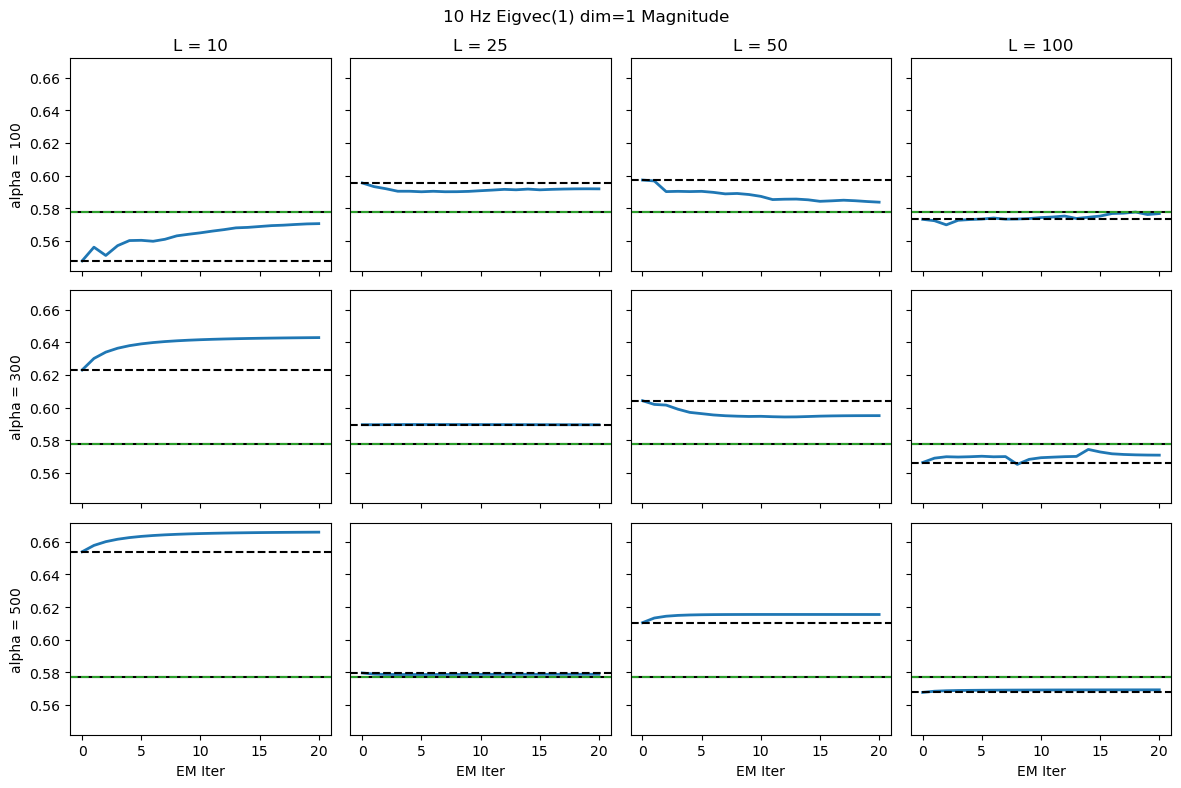

In [33]:
eigrank = 1
j_ind_full = 9
func = jnp.abs
dim = 1
fig, ax = plt.subplots(alphas.size, Ls.size, figsize=(12,8), sharex=True, sharey=True)
for l, L in enumerate(Ls):
    for a, alpha in enumerate(alphas):
        
        lsel = {'L': L}
        osel = {'alpha': alpha}
        res = filter_loaded(res_load, lsel, msel, osel)
        cfg = res['cfg']
        gamma_true = res['gamma_true_full']


        gamma_naive = naive_ests[l,a,:,:,:]
        gamma_oracle = oracle_ests[l,a,:,:,:]

        true_eigvec = get_eigvec(gamma_true[jind_full,:,:], eigrank)
        oracle_eigvec = get_eigvec(gamma_oracle[jind,:,:], eigrank)
        naive_eigvec = get_eigvec(gamma_naive[jind,:,:], eigrank)

        plot_eigvec_func_em_iters(ax[a,l], func, eigrank, dim, res['track']['gamma'], res['gamma_init'], j_ind=9)
        ax[a,l].axhline(func(true_eigvec[dim]), color='k')
        ax[a,l].axhline(func(naive_eigvec[dim]), linestyle='--', color='k')
        ax[a,l].axhline(func(oracle_eigvec[dim]), linestyle='--', color='tab:green')


        if l == 0:
            ax[a,l].set_ylabel(f'alpha = {alpha}')
        if a == 0:
            ax[a,l].set_title(f'L = {L}')
        if a == alphas.size-1:
            ax[a,l].set_xlabel('EM Iter')

fig.suptitle(f'{nz[jind]+1} Hz ' + rf'Eigvec({eigrank}) dim={dim} Magnitude')
plt.tight_layout()

Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.


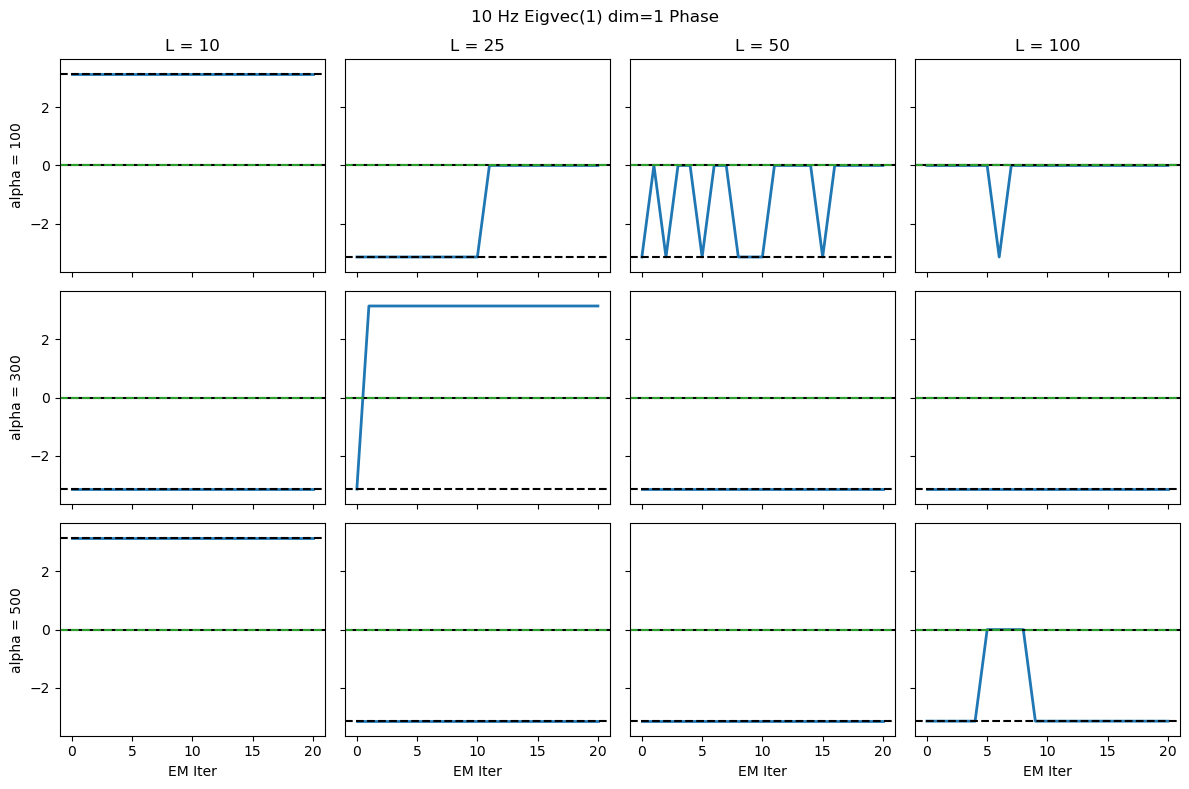

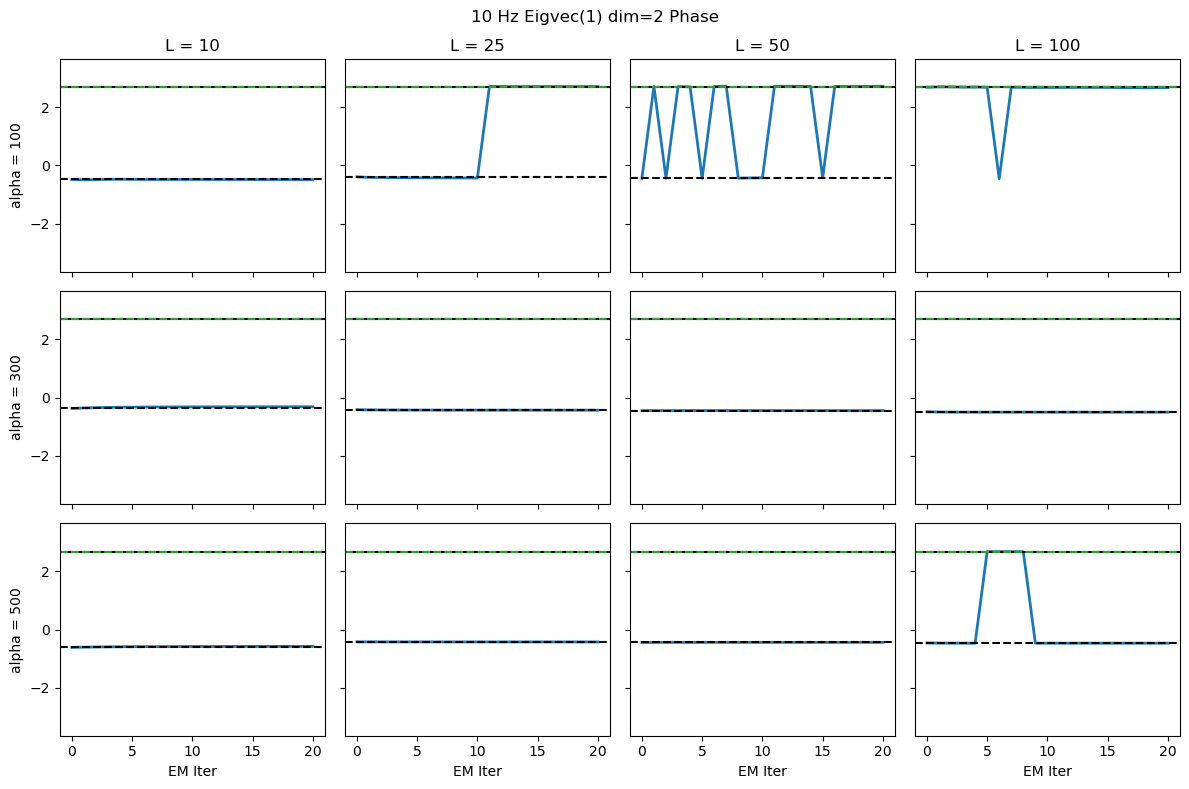

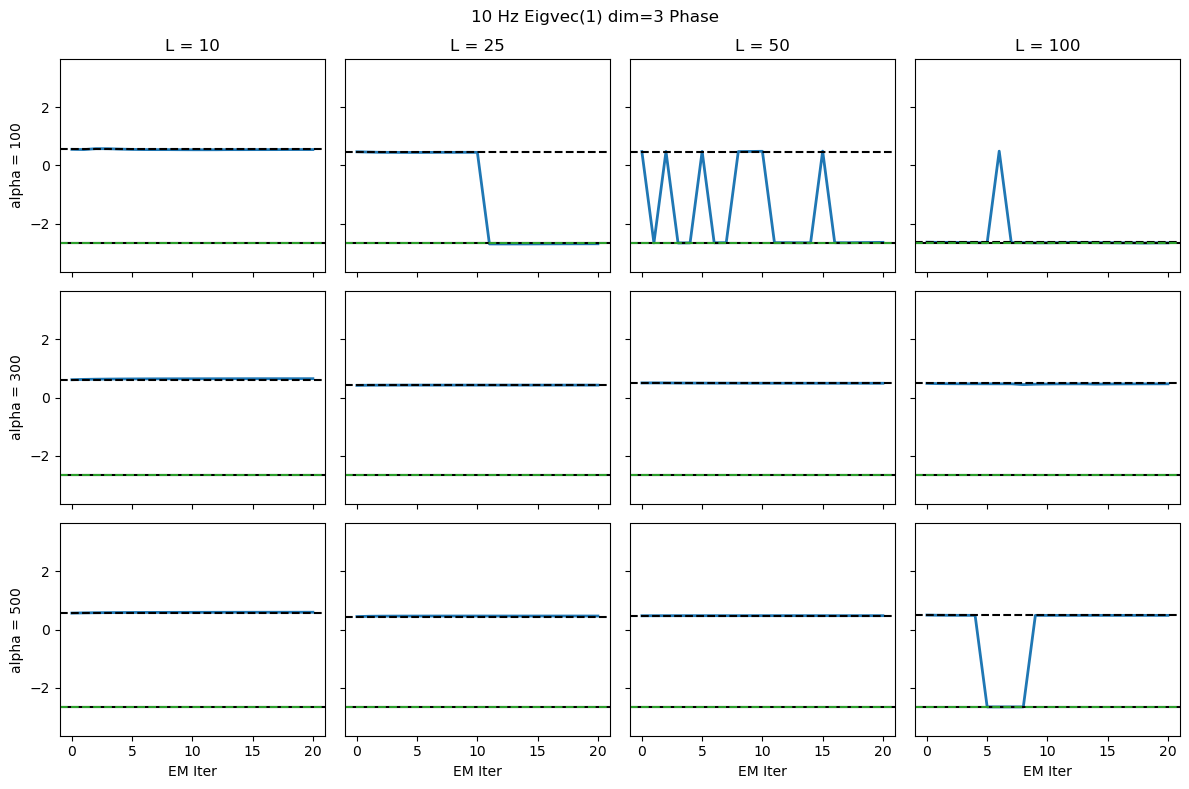

In [34]:
eigrank = 1
func = jnp.angle
for dim in range(K):
    fig, ax = plt.subplots(alphas.size, Ls.size, figsize=(12,8), sharex=True, sharey=True)
    for l, L in enumerate(Ls):
        for a, alpha in enumerate(alphas):
            
            lsel = {'L': L}
            osel = {'alpha': alpha}
            res = filter_loaded(res_load, lsel, msel, osel)
            cfg = res['cfg']
            gamma_true = res['gamma_true_full']


            gamma_naive = naive_ests[l,a,:,:,:]
            gamma_oracle = oracle_ests[l,a,:,:,:]

            true_eigvec = get_eigvec(gamma_true[jind_full,:,:], eigrank)
            oracle_eigvec = get_eigvec(gamma_oracle[jind,:,:], eigrank)
            naive_eigvec = get_eigvec(gamma_naive[jind,:,:], eigrank)

            plot_eigvec_func_em_iters(ax[a,l], func, eigrank, dim, res['track']['gamma'], res['gamma_init'], j_ind=9)
            ax[a,l].axhline(func(true_eigvec[dim]), color='k')
            ax[a,l].axhline(func(naive_eigvec[dim]), linestyle='--', color='k')
            ax[a,l].axhline(func(oracle_eigvec[dim]), linestyle='--', color='tab:green')


            if l == 0:
                ax[a,l].set_ylabel(f'alpha = {alpha}')
            if a == 0:
                ax[a,l].set_title(f'L = {L}')
            if a == alphas.size-1:
                ax[a,l].set_xlabel('EM Iter')
            ax[a,l].set_ylim([-jnp.pi - 0.5, jnp.pi + 0.5])

    fig.suptitle(f'{nz[jind]+1} Hz ' + rf'Eigvec({eigrank}) dim={dim+1} Phase')
    plt.tight_layout()